In [2]:
# Импортируем нужные библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [3]:
# Читаем наш датасет 
df = pd.read_csv('people_data_clustering.csv')
print('Размеры',df.shape)
df.head()

Размеры (6000, 10)


,id,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
0,0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


Чистка датасета (5 баллов)
1. Есть ли дубли в данных? Если есть удалить. 
2. Найти и удалить выбросы по признаку home_cost. (Их не больше 15-х, не меньше 3-х)

In [19]:
#1 Убираем дубли в данных (14)
df = df.drop_duplicates(keep=False)
print('Размеры',df.shape)

Размеры (5986, 10)


Используем метод IQR для выявления выбросов, чтобы установить «забор» за пределами Q1 и Q3. Любые значения, выходящие за пределы этой границы, считаются выбросами. Чтобы построить этот забор, мы берем IQR в 1,5 раза, затем вычитаем это значение из Q1 и добавляем это значение к Q3.

,id,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
0,0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
...,...,...,...,...,...,...,...,...,...,...
5995,495,1,0.0,3.589436e+07,1,3.0,Executive,1.007038e+07,1.0,0.599222
5996,496,1,3.0,2.454208e+06,0,20.0,Homemaker,1.009348e+07,1.0,0.259710
5997,497,1,0.0,3.335405e+06,0,17.0,Healthcare,1.016696e+07,0.0,0.258779
5998,498,0,1.0,2.024255e+08,0,10.0,Lawyer,1.025544e+07,NaN,0.212931


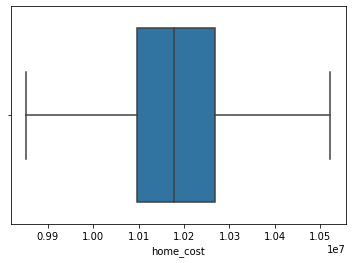

In [15]:
import seaborn as sns
sns.boxplot(x=df['home_cost'])

# функция для нахождения выбросов по Q1 и Q3 
def outliers_iqr(q):
    quartile_1, quartile_3 = np.percentile(q, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((q > upper_bound) | (q < lower_bound))

outliers=outliers_iqr(df['home_cost'])


# Убираем выбросы
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


df = remove_outlier(df, 'home_cost')
df 

Гистограмма отображает частоту (количество) числовой переменной, разбивая ее на ячейки (интервалы). 
Чтобы помочь определить разумную ширину бина, мы можем использовать правило Фридмана-Диакониса, которое было разработано для минимизации разницы между площадью под эмпирическим распределением вероятностей и площадью под теоретическим распределением вероятностей. Формально правило принимает в качестве входных данных межквартильный диапазон IQR(x) и количество наблюдений n в наборе эмпирических данных и возвращает оценку ширины бина.

In [20]:
x=df['salary']
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
#plt.hist(x, bins=bins);

Freedman–Diaconis number of bins: 21


Гипотеза: 
1. Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?

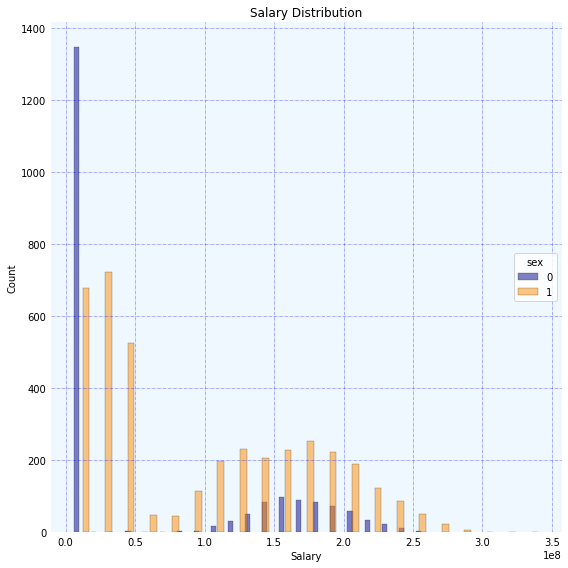

In [21]:
import matplotlib.pyplot as plt
A = df.loc[df['sex'] == 0]  # женский пол 
B = df.loc[df['sex'] == 1]  # мужской пол  

fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Убираем x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Добавим padding между axes and labels
axs.xaxis.set_tick_params(pad = 1)
axs.yaxis.set_tick_params(pad = 1)
 
# Добавим клеточки 
axs.grid(visible = True, color ='blue',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

#Фоновый цвет 
axs.set_facecolor('aliceblue')
 

#Добавим гистограмму 
plt.hist(A['salary'], alpha=0.5, label='0', color="darkblue", histtype='barstacked', bins=21, edgecolor="black", linewidth=0.4, rwidth=0.3)
plt.hist(B['salary'], alpha=0.5, label='1', color ="darkorange", histtype='barstacked', bins=21, edgecolor='black', linewidth=0.4, rwidth=0.3)



#Довавляем титул, и название осей 
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Count')

# 
legend = plt.legend(loc = "center right")
legend.set_title("sex")
#Нарисуем гистограмму 
plt.show()
